# Projeto de Redes Sociais

Cicero Tiago Carneiro Valentim

Lais Nascimento da Silva

Thalia Loiola da Silva

William Augusto Reis da Silva

### Bibliotecas

In [1]:
from graph_tool import centrality, clustering, PropertyMap
from graph_tool import Graph
from datetime import datetime
from netpixi.data.gt import *
from netpixi import render, peek
import matplotlib.pyplot as plt
import netpixi
import pandas as pd
import netpixi
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
df = pd.read_excel('netflix.xlsx')
df = df.dropna(subset=['Genre'])
df = df.reset_index()
df.head()

,index,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Country Availability,Runtime,Director,...,Netflix Release Date,Production House,Netflix Link,IMDb Link,Summary,IMDb Votes,Image,Poster,TMDb Trailer,Trailer Site
0,0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,Thailand,< 30 minutes,Tomas Alfredson,...,2021-03-04,"Canal+, Sandrew Metronome",https://www.netflix.com/watch/81415947,https://www.imdb.com/title/tt1139797,A med student with a supernatural gift tries t...,205926.0,https://occ-0-4708-64.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BOWM4NT...,https://www.youtube.com/watch?v=LqB6XJix-dM,YouTube
1,1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,Canada,1-2 hour,Coky Giedroyc,...,2021-03-04,"Film 4, Monumental Pictures, Lionsgate",https://www.netflix.com/watch/81041267,https://www.imdb.com/title/tt4193072,"When nerdy Johanna moves to London, things get...",2838.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BZGUyN2...,https://www.youtube.com/watch?v=eIbcxPy4okQ,YouTube
2,2,The Con-Heartist,"Comedy, Romance","Romantic Comedies,Comedies,Romantic Films,Thai...",Thai,Movie,8.6,Thailand,> 2 hrs,Mez Tharatorn,...,2021-03-03,NaN,https://www.netflix.com/watch/81306155,https://www.imdb.com/title/tt13393728,After her ex-boyfriend cons her out of a large...,131.0,https://occ-0-2188-64.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BODAzOG...,https://www.youtube.com/watch?v=md3CmFLGK6Y,YouTube
3,3,Gleboka woda,Drama,"TV Dramas,Polish TV Shows,Social Issue TV Dramas",Polish,Series,8.7,Poland,< 30 minutes,NaN,...,2021-03-03,NaN,https://www.netflix.com/watch/81307527,https://www.imdb.com/title/tt2300049,A group of social welfare workers led by their...,47.0,https://occ-0-2508-2706.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BMTc0Nz...,https://www.youtube.com/watch?v=5kyF2vy63r0,YouTube
4,4,Only a Mother,Drama,"Social Issue Dramas,Dramas,Movies Based on Boo...",Swedish,Movie,8.3,"Lithuania,Poland,France,Italy,Spain,Greece,Bel...",1-2 hour,Alf Sjöberg,...,2021-03-03,NaN,https://www.netflix.com/watch/81382068,https://www.imdb.com/title/tt0041155,An unhappily married farm worker struggling to...,88.0,https://occ-0-2851-41.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BMjVmMz...,https://www.youtube.com/watch?v=H0itWKFwMpQ,YouTube


In [4]:
df["Release Date"].describe()

count                    9196
unique                   4349
top       2018-09-21 00:00:00
freq                       20
first     1913-10-27 00:00:00
last      2021-11-12 00:00:00
Name: Release Date, dtype: object

### Separando antes/depois do streaming

Não há uma data exata que separa o "antes" e o "depois" do streaming, uma vez ele já existe há quase duas décadas e até hoje está se popularizando. Por conveniência, vamos assumir que esse limiar é 2010, o ano em que a Netflix passou a oferecer [serviço de streaming fora dos Estados Unidos](https://pt.wikipedia.org/wiki/Netflix).

In [5]:
# 01 de janeiro de 2010
limiar = datetime.strptime('2010-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')

In [6]:
df_before = df.copy(deep=True)[df["Release Date"] < limiar] # antes de 2010
df_after  = df.copy(deep=True)[df["Release Date"] > limiar] # depois de 2010

In [7]:
df_before["Release Date"].describe()

count                    2844
unique                   1988
top       2006-10-20 00:00:00
freq                       13
first     1913-10-27 00:00:00
last      2009-12-25 00:00:00
Name: Release Date, dtype: object

In [8]:
df_after["Release Date"].describe()

count                    6351
unique                   2360
top       2018-09-21 00:00:00
freq                       20
first     2010-01-04 00:00:00
last      2021-11-12 00:00:00
Name: Release Date, dtype: object

In [9]:
titles_before = df_before["Title"].tolist() # títulos de filme  e séries antes
titles_after  = df_after["Title"].tolist()  # títulos de filmes e séries depois

In [10]:
def filter_graph(v_property:str, test_function):
    g = load_gt('projeto-one-mode-dicotomizado.net.gz')
    indexes_to_remove = []
    for v in g.vertices():
        if not test_function(g.vp[v_property][v]):
            indexes_to_remove.append(v)
    g.remove_vertex(indexes_to_remove)
    return g

In [11]:
g_before = filter_graph('nome', lambda name: name in titles_before)

In [12]:
g_after = filter_graph('nome', lambda name: name in titles_after)

In [13]:
save_gt(g_before, 'g_before-streaming.net.gz')

In [14]:
save_gt(g_after, 'g_after-streaming.net.gz')

### Antes do Streaming

In [15]:
def with_scores(source_df, graph_df):
    # recebe como argumento um dataframe com todas as colunas e um dataframe obtido a partir do grafo
    source_df = source_df.copy()
    graph_df = graph_df.copy()
    
    # cria um novo dataframe com as colunas ["reputação", "nome"]
    columns = { "Rotten Tomatoes Score": "reputacao", "Title": "nome" }
    df_scores = source_df[list(columns.keys())].rename(columns=columns)
    
    # garante que os tipos são compatíveis entre as duas
    df_scores.nome = df_scores.nome.astype(str, copy=False)
    graph_df.nome  = graph_df.nome.astype(str, copy=False)
    graph_df.id    = graph_df.id.astype(int, copy=False)
    
    # faz uma limpeza simples de valores ausentes e seta o index pra coluna comum dos dois DFs
    df_scores = df_scores.drop_duplicates(subset=['nome'], keep=False)
    df_scores = df_scores.dropna()
    df_scores = df_scores.set_index('nome')
    
    # faz um 'join' dos dois DFs em relação à coluna comum
    graph_df = graph_df.set_index('nome')
    graph_df = graph_df.join(df_scores, how='left')
    graph_df = graph_df.reset_index()
    graph_df = graph_df.dropna(subset=['reputacao'])
    
    return graph_df

In [16]:
# calculo clustering coefficient
c = clustering.local_clustering(g_before)

# calculo betweenness
bc, _ = centrality.betweenness(g_before)

# calculo degree
dc = degree_gt(g_before)

g_before.vp['betweenness'] = bc
g_before.vp['clustering'] = c
g_before.vp['degree'] = dc

In [17]:
before_streaming = pd.DataFrame({k: list(v) for k, v in g_before.vp.items()})

In [18]:
before_streaming.head()

,id,nome,_x,_y,betweenness,clustering,degree
0,0,Lets Fight Ghost,-1.436253,77.806371,0.000008,0.928571,0.002875
1,4,Only a Mother,698.456925,1632.287651,0.000000,0.000000,0.000000
2,5,Snowroller,807.543769,1008.637190,0.000000,0.000000,0.000000
3,6,The Invisible,55.645344,122.529907,0.000048,0.676459,0.025512
4,7,The Simple Minded Murderer,-1144.111152,-437.080844,0.000000,0.000000,0.000000


In [19]:
b_wscores = with_scores(source_df=df_before, graph_df=before_streaming)

In [20]:
b_wscores.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
0,Lets Fight Ghost,0,-1.436253,77.806371,0.000008,0.928571,0.002875,98.0
3,The Invisible,6,55.645344,122.529907,0.000048,0.676459,0.025512,20.0
4,The Simple Minded Murderer,7,-1144.111152,-437.080844,0.000000,0.000000,0.000000,92.0
5,I,10,81.874520,73.708312,0.000000,1.000000,0.016529,52.0
6,Comrades: Almost a Love Story,16,1413.097246,44.633800,0.000000,0.000000,0.000000,89.0


### Depois do Streaming

In [21]:
# calculo clustering coefficient
c = clustering.local_clustering(g_after)

# calculo betweenness
bc, _ = centrality.betweenness(g_after)

# calculo degree
dc = degree_gt(g_after)

g_after.vp['betweenness'] = bc
g_after.vp['clustering'] = c
g_after.vp['degree'] = dc

In [22]:
after_streaming = pd.DataFrame({k: list(v) for k, v in g_after.vp.items()})

In [23]:
after_streaming.head()

,id,nome,_x,_y,betweenness,clustering,degree
0,1,HOW TO BUILD A GIRL,-229.729180,1039.631642,0.0,0.0,0.0
1,2,The Con-Heartist,854.216640,357.749654,0.0,0.0,0.0
2,3,Gleboka woda,-62.084147,-830.782865,0.0,0.0,0.0
3,8,To Kill a Child,477.886939,1357.210557,0.0,0.0,0.0
4,9,Joker,-723.304606,1483.995708,0.0,0.0,0.0


In [24]:
a_wscores = with_scores(source_df=df_after, graph_df=after_streaming)

In [25]:
a_wscores.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
0,HOW TO BUILD A GIRL,1,-229.729180,1039.631642,0.0,0.0,0.000000,79.0
5,Harrys Daughters,11,96.413293,74.948004,0.0,1.0,0.002421,96.0
10,Trial by Fire,26,-692.380026,-1411.460985,0.0,0.0,0.000000,61.0
15,Framing John DeLorean,34,208.197817,-1210.457887,0.0,0.0,0.000000,90.0
18,Paths of the Soul,40,26.661152,-1401.168557,0.0,0.0,0.000000,94.0


### Plots dos gráficos

In [26]:
sns.set()

#### Antes do Streaming

In [27]:
# pegamos apenas os betweenness com valores > 0 (bwsp = 'before with scores & positive betweenness') 
bwsp = b_wscores[b_wscores['betweenness'] > 0]
bwsp.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
0,Lets Fight Ghost,0,-1.436253,77.806371,0.000008,0.928571,0.002875,98.0
3,The Invisible,6,55.645344,122.529907,0.000048,0.676459,0.025512,20.0
29,The Shadow,89,67.704799,97.362622,0.000180,0.426667,0.027309,35.0
31,Awara Paagal Deewana,93,65.344360,120.645456,0.000306,0.511015,0.044556,54.0
32,Repo Man,96,83.066718,105.618139,0.000092,0.621943,0.019404,98.0


**Betweenness isolado**

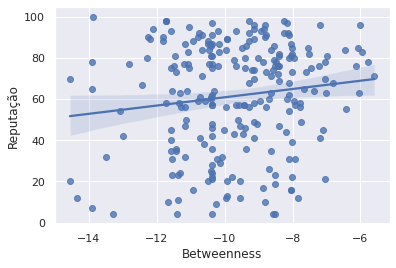

In [69]:
x = np.log(bwsp['betweenness'])
before_ax = sns.regplot(x=x, y=bwsp['reputacao'])
before_ax.set(xlabel="Betweenness", ylabel="Reputação")
plt.show()

In [70]:
model_b  = smf.ols(data=bwsp, formula='reputacao ~ np.log(betweenness)')
result_b = model_b.fit()
result_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.305
Date:                Mon, 29 Nov 2021   Prob (F-statistic):             0.0391
Time:                        15:00:09   Log-Likelihood:                -1112.1
No. Observations:                 238   AIC:                             2228.
Df Residuals:                     236   BIC:                             2235.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              80.9686      9.527      8.499      0.000      62.199      99.738
np.log(betweenness)     2.0081      0.968      2.075      0.039       0.101       3.915
==============================================================================
Omnibus:                       24.471   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.999
Skew:                          -0.505   Prob(JB):                     0.000336
Kurtosis:                       2.229   Cond. No.                         56.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Betweenness + Clustering + Degree**

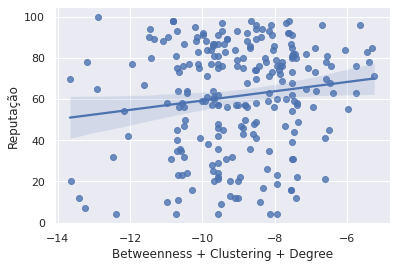

In [73]:
x = np.log(bwsp['betweenness']) + bwsp['clustering'] + bwsp['degree']
before_ax = sns.regplot(x=x, y=bwsp['reputacao'])
before_ax.set(xlabel="Betweenness + Clustering + Degree", ylabel="Reputação")
plt.show()

In [76]:
model_b  = smf.ols(data=bwsp, formula='reputacao ~ np.log(betweenness) + clustering + degree')
result_b = model_b.fit()
result_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.581
Date:                Mon, 29 Nov 2021   Prob (F-statistic):             0.0542
Time:                        15:05:22   Log-Likelihood:                -1110.4
No. Observations:                 238   AIC:                             2229.
Df Residuals:                     234   BIC:                             2243.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              87.8268     12.541      7.003      0.000      63.119     112.534
np.log(betweenness)     4.4143      1.644      2.684      0.008       1.174       7.654
clustering             28.4020     15.692      1.810      0.072      -2.513      59.317
degree                -56.2681     90.542     -0.621      0.535    -234.649     122.113
==============================================================================
Omnibus:                       27.960   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.793
Skew:                          -0.476   Prob(JB):                     0.000372
Kurtosis:                       2.171   Cond. No.                         537.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Análise breve:**
- Coeficiente (logarítmico) considerável relacionando _betweenness_ e reputação;
- p-valor pequeno, indicando que podemos desprezar a hipótese nula (não há relação);

---

#### Depois do Streaming

In [30]:
awsp = a_wscores[a_wscores['betweenness'] > 0] # awsp = 'after with scores & positive betweenness'
awsp.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
34,Ride Your Wave,62,44.678612,36.371525,0.000372,0.448572,0.041162,93.0
94,Trolls World Tour,161,63.218041,34.246239,0.000015,0.719575,0.042292,70.0
95,Ace Attorney,162,69.000390,129.286482,0.000078,0.673988,0.023083,66.0
137,On Happiness Road,219,54.269257,40.908359,0.000006,0.822610,0.030024,100.0
182,Lizzie,290,45.374297,150.648035,0.000260,0.712217,0.021792,66.0


**Betweenness isolado**

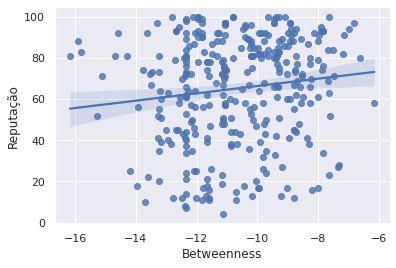

In [77]:
x = np.log(awsp['betweenness'])
after_ax = sns.regplot(x=x, y=awsp['reputacao'])
after_ax.set(xlabel='Betweenness', ylabel="Reputação")
plt.show()

In [78]:
model_a  = smf.ols(data=awsp, formula='reputacao ~ np.log(betweenness)')
result_a = model_a.fit()
result_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.386
Date:                Mon, 29 Nov 2021   Prob (F-statistic):             0.0209
Time:                        15:36:46   Log-Likelihood:                -1565.6
No. Observations:                 336   AIC:                             3135.
Df Residuals:                     334   BIC:                             3143.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              84.1465      8.322     10.111      0.000      67.776     100.517
np.log(betweenness)     1.7795      0.767      2.321      0.021       0.271       3.288
==============================================================================
Omnibus:                       32.252   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.730
Skew:                          -0.584   Prob(JB):                     2.59e-06
Kurtosis:                       2.311   Cond. No.                         65.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Betweenness + Clustering + Degree**

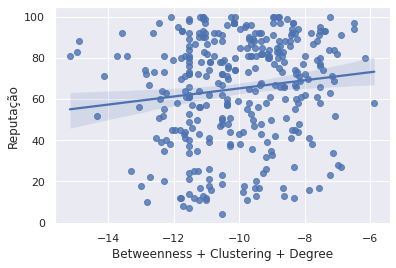

In [80]:
x = np.log(awsp['betweenness']) + awsp['clustering'] + awsp['degree']
after_ax = sns.regplot(x=x, y=awsp['reputacao'])
after_ax.set(xlabel='Betweenness + Clustering + Degree', ylabel="Reputação")
plt.show()

In [81]:
model_a  = smf.ols(data=awsp, formula='reputacao ~ np.log(betweenness) + clustering + degree')
result_a = model_a.fit()
result_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.483
Date:                Mon, 29 Nov 2021   Prob (F-statistic):             0.0161
Time:                        15:41:24   Log-Likelihood:                -1563.1
No. Observations:                 336   AIC:                             3134.
Df Residuals:                     332   BIC:                             3149.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              76.6981      9.568      8.016      0.000      57.877      95.519
np.log(betweenness)     1.7222      1.246      1.383      0.168      -0.728       4.172
clustering              3.8957     12.252      0.318      0.751     -20.205      27.997
degree                183.5611     84.679      2.168      0.031      16.986     350.136
==============================================================================
Omnibus:                       29.323   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.472
Skew:                          -0.575   Prob(JB):                     4.85e-06
Kurtosis:                       2.348   Cond. No.                         665.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Análise breve:**
- Coeficiente (logarítmico) considerável relacionando _betweenness_ e reputação;
- p-valor pequeno, indicando que podemos desprezar a hipótese nula (não há relação);

---

**O que mudou no antes/depois (supondo que há relação)**

Ambos os parâmetros analisados (coeficiente e p-valor) diminuíram entre os dois períodos. A Diminuição do coeficiente pode indicar que a relação entre __betweenness__ e __reputação__ foi enfraquecida com o aumento da popularização do Streaming. Por outro lado, observando a variação do p-valor, é possível que a relação seja mais confiável.